
Самостоятельно напишите нейронную сеть, которая поможет распознавать болезни по симптомам. Используя подготовленную базу, создайте и обучите нейронную сеть, распознающую десять категорий
заболеваний: аппендицит, гастрит, гепатит, дуоденит, колит, панкреатит, холицестит, эзофагит, энтерит, язва. Добейтесь правильного распознавания 6 и более заболеваний

Сразу обратим внимание датасет небольшой и хороших результатов добится  сложно.

Ссылка на датасет:https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip

## **Подключение библиотек**

In [ ]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

from tensorflow.keras.optimizers import Adam, RMSprop

%matplotlib inline

## **Загрузка данных**

In [ ]:
# Скачаем архив с симптомами болезней
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip', None, quiet=True)

'diseases.zip'

In [ ]:
# Распакум архив
!unzip -o diseases.zip

Archive:  diseases.zip
  inflating: dis/Аппендицит.txt  
  inflating: dis/Гастрит.txt  
  inflating: dis/Гепатит.txt  
  inflating: dis/Дуоденит.txt  
  inflating: dis/Колит.txt      
  inflating: dis/Панкреатит.txt  
  inflating: dis/Холицестит.txt  
  inflating: dis/Эзофагит.txt  
  inflating: dis/Энтерит.txt  
  inflating: dis/Язва.txt        


In [ ]:
FILE_DIR  = 'dis/'                     # Папка с текстовыми файлами

In [ ]:
# Подготовим пустые списки

CLASS_LIST = []  # Список классов
text_train = []  # Список для оучающей выборки
text_test = []   # Список для тестовой выборки

# Зададим коэффициент разделения текста на обучающую и текстовую выборки
split_coef = 0.8

# Получим списки файлов в папке
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    m = file_name.split('.') # Разделим имя файла и расширение
    class_name = m[0]        # Из имени файла получим название класса
    ext = m[1]               # Выделим расширение файла

    if ext=='txt':                                         # Если расширение txt то берем файл в работу
        if class_name not in CLASS_LIST:                   # Проверим, есть уже такой класс в списке
            print(f'Добавление класса "{class_name}"')     # Выведем имя нового класса
            CLASS_LIST.append(class_name)                  # Добавим новый класс в списоккласса "{class_name}"')

        cls = CLASS_LIST.index(class_name)                                        # Получим индекс (номер) нового класса
        print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}"')      # Сообщим о появлении нового класса

        with open(f'{FILE_DIR}/{file_name}', 'r') as f: # Откроем файл на чтение
            text = f.read()                                                       # Загрузка содержимого файла в строку
            text = text.replace('\n', ' ').split(' ')                             # Уберем символы перевода строк, получим список слов
            text_len=len(text)                                                    # Найдем количество прочитанных слов
            text_train.append(' '.join(text[:int(text_len*split_coef)]))          # Выделим часть файла в обучающую выборку
            text_test.append(' '.join(text[int(text_len*split_coef):]))           # Выделим часть файла в тестовую выборку



Добавление класса "Эзофагит"
Добавление файла "Эзофагит.txt" в класс "Эзофагит"
Добавление класса "Аппендицит"
Добавление файла "Аппендицит.txt" в класс "Аппендицит"
Добавление класса "Язва"
Добавление файла "Язва.txt" в класс "Язва"
Добавление класса "Холицестит"
Добавление файла "Холицестит.txt" в класс "Холицестит"
Добавление класса "Гепатит"
Добавление файла "Гепатит.txt" в класс "Гепатит"
Добавление класса "Энтерит"
Добавление файла "Энтерит.txt" в класс "Энтерит"
Добавление класса "Гастрит"
Добавление файла "Гастрит.txt" в класс "Гастрит"
Добавление класса "Дуоденит"
Добавление файла "Дуоденит.txt" в класс "Дуоденит"
Добавление класса "Колит"
Добавление файла "Колит.txt" в класс "Колит"
Добавление класса "Панкреатит"
Добавление файла "Панкреатит.txt" в класс "Панкреатит"


In [ ]:
# Найдем получившееся количество классов
CLASS_COUNT = len(CLASS_LIST)

In [ ]:
# Выведем число получившихся классов
print(CLASS_COUNT)

10


In [ ]:
# Проверим загрузки: выведем начальные отрывки из каждого класса

for cls in range(CLASS_COUNT):             # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')     # Выведем имя класса
    print(f'  train: {text_train[cls]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls]}')    # Выведем фрагмент тестовой выборки
    print()

Класс: Эзофагит
  train: затруднения и болезненные ощущения при глотании изжога боли во рту ощущения чего-то застрявшего в горле тошнота рвота  боль при глотании и в состоянии покоя жжение изжога ком в горле болезненные ощущения во рту  неприятный привкус охриплость язвы во рту боль не только в пищеводе и в грудине, отдающая в спину неприятный запах изо рта  затруднённое прохождение пищи по пищеводу  может повышаться температура тела общее недомогание неприятные ощущения по ходу пищевода во время продвижения пищи может беспокоить жжение иногда резкая боль в пищеводе боль в области шеи отрыжка слюнотечение нарушается глотание  боли за грудиной и в подложечной области сочетается с гастритом или дуоденитом чувство саднения за грудиной непосредственно после проглатывания пищи боли, не зависящие от приёма пищи изжога вечером и ночью тошнота рвота икота слюнотечение затрудненное дыхание Икота   дисфагия (затрудненное и болезненное глотание) изжога ощущение кома в горле тошнота срыгивание съе

In [ ]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with

class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

## **Подготовка данных**

In [ ]:
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)
    x, y = [], []

    for cls in range(class_count):
        vectors = split_sequence(seq_list[cls], win_size, hop)
        x += vectors
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    return np.array(x), np.array(y)

In [ ]:
VOCAB_SIZE = 5000
WIN_SIZE   = 50
WIN_HOP    = 5

In [ ]:
with timex():
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    tokenizer.fit_on_texts(text_test)
    items = list(tokenizer.word_index.items())

Время обработки: 0.02 с


In [ ]:
with timex():
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", text_test[1][:101])
    print("Он же в виде последовательности индексов: ", seq_test[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:               животу вызывает усиление болевых ощущений. Мышцы живота напряжены. Больной поджимает ноги к животу. П
Он же в виде последовательности индексов:  [444, 1734, 797, 466, 357, 849, 9, 850, 408, 1735, 1736, 32, 444, 147, 5, 3, 7, 450, 86, 67]
Время обработки: 0.01 с


In [ ]:
with timex():
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(1220, 50) (1220, 10)
(233, 50) (233, 10)
Время обработки: 0.01 с


## **Сервисные функции**

In [ ]:
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer = Adam(0.00001),
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Вывод схемы модели
    display(plot_model(model, dpi=60, show_shapes=True))

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

## **Создание и обучение модели**

In [ ]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_6.add(SpatialDropout1D(0.4))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_6.add(GRU(16, reset_after=True))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Dense(200, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
model_LSTM_6.add(Dense(CLASS_COUNT, activation='softmax'))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            250000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_8 (Batc  (None, 50, 50)           200       
 hNormalization)                                                 
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 16)           3776      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 16)           1600      
 nal)                                                 

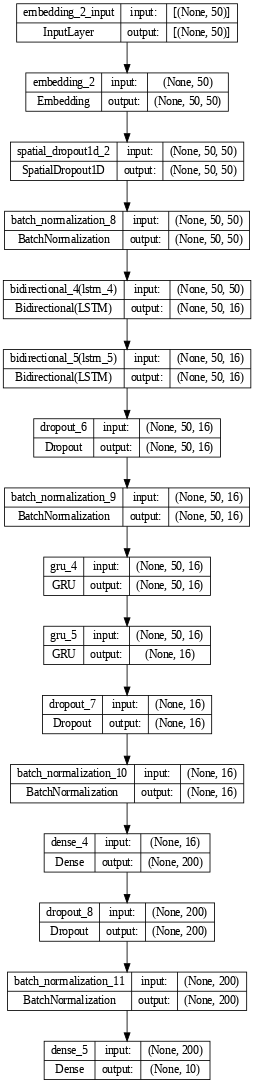

Epoch 1/50
39/39 [==============================] - 13s 112ms/step - loss: 0.0932 - accuracy: 0.9762 - val_loss: 3.3833 - val_accuracy: 0.5236
Epoch 2/50
39/39 [==============================] - 3s 70ms/step - loss: 0.0578 - accuracy: 0.9803 - val_loss: 3.1859 - val_accuracy: 0.5536
Epoch 3/50
39/39 [==============================] - 3s 86ms/step - loss: 0.0560 - accuracy: 0.9869 - val_loss: 3.4672 - val_accuracy: 0.5150
Epoch 4/50
39/39 [==============================] - 3s 69ms/step - loss: 0.0730 - accuracy: 0.9770 - val_loss: 3.1148 - val_accuracy: 0.5665
Epoch 5/50
39/39 [==============================] - 3s 69ms/step - loss: 0.0756 - accuracy: 0.9803 - val_loss: 3.1979 - val_accuracy: 0.5408
Epoch 6/50
39/39 [==============================] - 3s 69ms/step - loss: 0.0536 - accuracy: 0.9926 - val_loss: 3.1103 - val_accuracy: 0.5322
Epoch 7/50
39/39 [==============================] - 3s 87ms/step - loss: 0.0702 - accuracy: 0.9795 - val_loss: 2.9786 - val_accuracy: 0.5536
Epoch 8/50


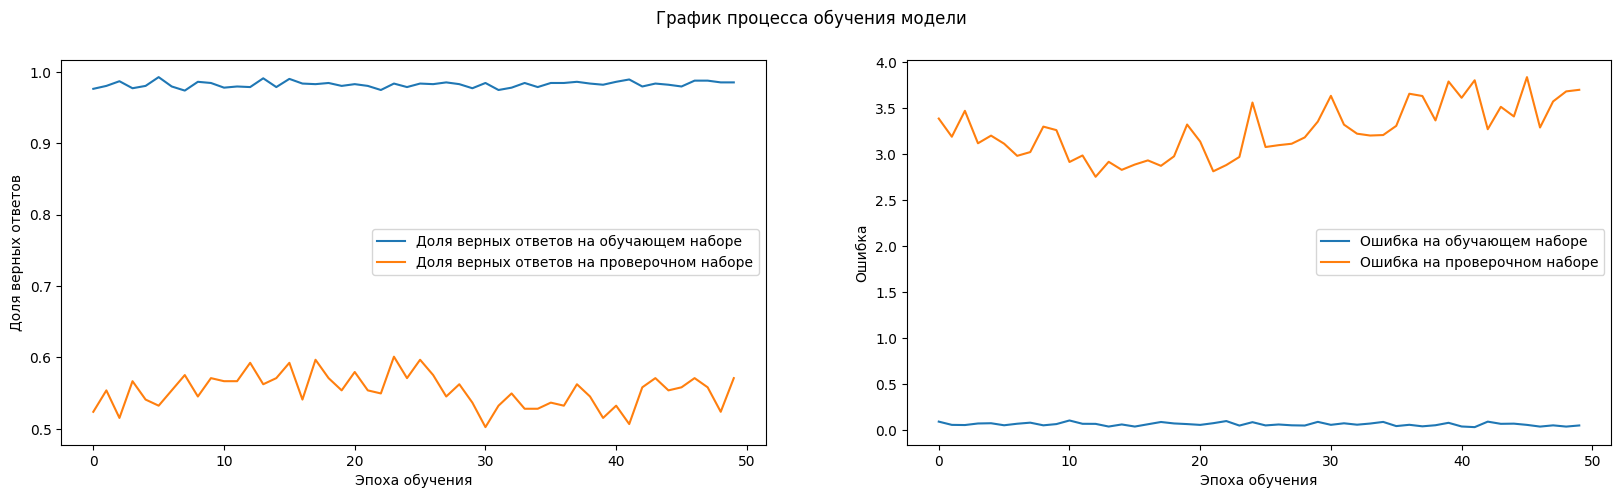

8/8 [==============================] - 2s 12ms/step


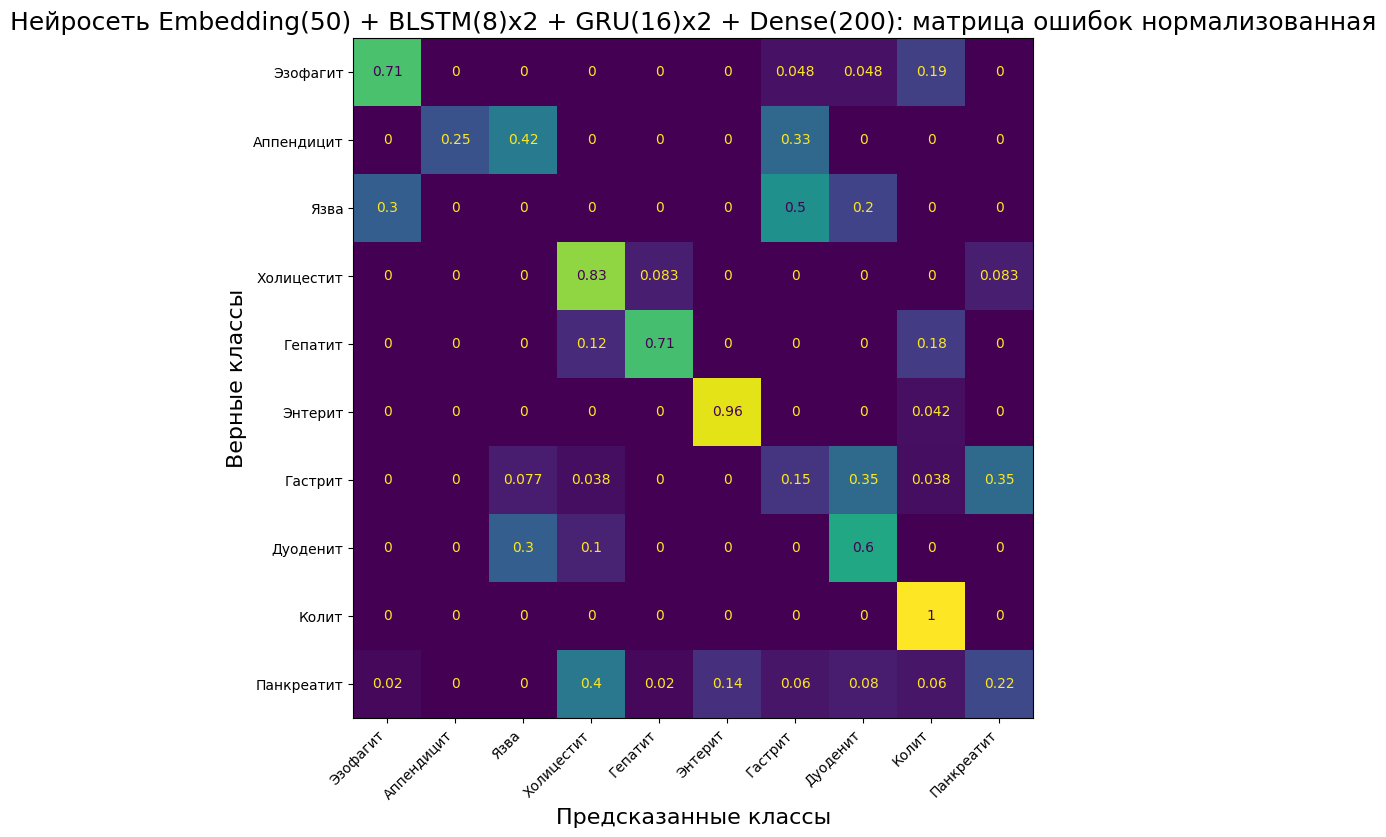

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Эзофагит              71% сеть отнесла к классу Эзофагит             - ВЕРНО :-)
Класс: Аппендицит            42% сеть отнесла к классу Язва                 - НЕВЕРНО :-(
Класс: Язва                  50% сеть отнесла к классу Гастрит              - НЕВЕРНО :-(
Класс: Холицестит            83% сеть отнесла к классу Холицестит           - ВЕРНО :-)
Класс: Гепатит               71% сеть отнесла к классу Гепатит              - ВЕРНО :-)
Класс: Энтерит               96% сеть отнесла к классу Энтерит              - ВЕРНО :-)
Класс: Гастрит               35% сеть отнесла к классу Дуоденит             - НЕВЕРНО :-(
Класс: Дуоденит              60% сеть отнесла к классу Дуоденит             - ВЕРНО :-)
Класс: Колит                100% сеть отнесла к классу Колит                - ВЕРНО :-)
Класс: Панкреатит            40% сеть 

In [ ]:
compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer=RMSprop(0.001),
                         epochs=50,
                         batch_size=32,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

In [ ]:
model_LSTM_1 = Sequential()
model_LSTM_1.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_1.add(SpatialDropout1D(0.4))
model_LSTM_1.add(BatchNormalization())

model_LSTM_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_1.add(Dropout(0.3))
model_LSTM_1.add(BatchNormalization())

model_LSTM_1.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_1.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_1.add(GRU(16, reset_after=True))
model_LSTM_1.add(Dropout(0.3))
model_LSTM_1.add(BatchNormalization())

model_LSTM_1.add(Dense(200, activation='relu'))
model_LSTM_1.add(Dropout(0.3))
model_LSTM_1.add(BatchNormalization())
model_LSTM_1.add(Dense(CLASS_COUNT, activation='softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            250000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 50, 50)           200       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 16)           3776      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 16)           1600      
 nal)                                                   

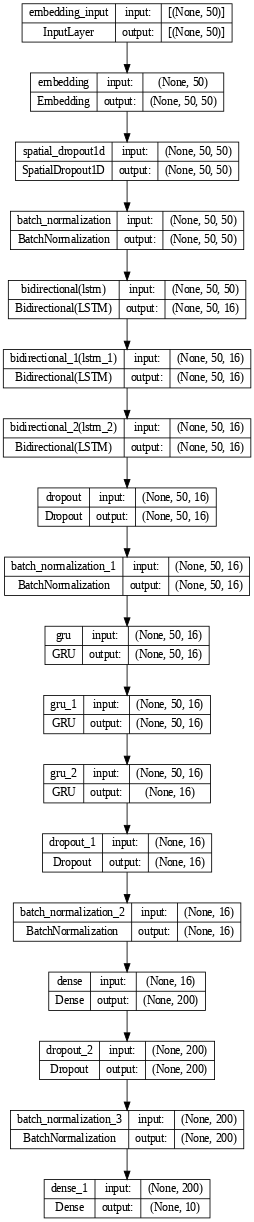

Epoch 1/50
39/39 [==============================] - 19s 171ms/step - loss: 2.6637 - accuracy: 0.1418 - val_loss: 2.2333 - val_accuracy: 0.2146
Epoch 2/50
39/39 [==============================] - 5s 120ms/step - loss: 2.2529 - accuracy: 0.2262 - val_loss: 2.2140 - val_accuracy: 0.2146
Epoch 3/50
39/39 [==============================] - 4s 98ms/step - loss: 1.7052 - accuracy: 0.4074 - val_loss: 2.2107 - val_accuracy: 0.2146
Epoch 4/50
39/39 [==============================] - 5s 119ms/step - loss: 1.1900 - accuracy: 0.5984 - val_loss: 2.1857 - val_accuracy: 0.2146
Epoch 5/50
39/39 [==============================] - 4s 114ms/step - loss: 0.8762 - accuracy: 0.7008 - val_loss: 2.1822 - val_accuracy: 0.2275
Epoch 6/50
39/39 [==============================] - 4s 99ms/step - loss: 0.6261 - accuracy: 0.7902 - val_loss: 2.2222 - val_accuracy: 0.1073
Epoch 7/50
39/39 [==============================] - 4s 115ms/step - loss: 0.4463 - accuracy: 0.8516 - val_loss: 2.1244 - val_accuracy: 0.1974
Epoch 8

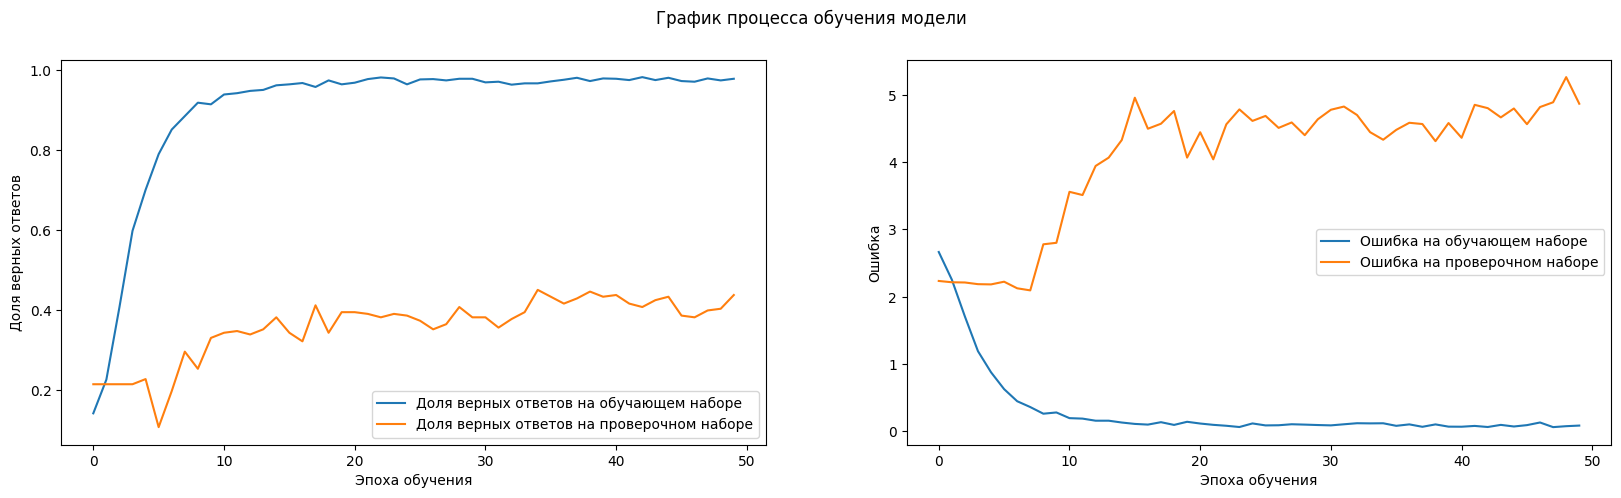

8/8 [==============================] - 2s 30ms/step


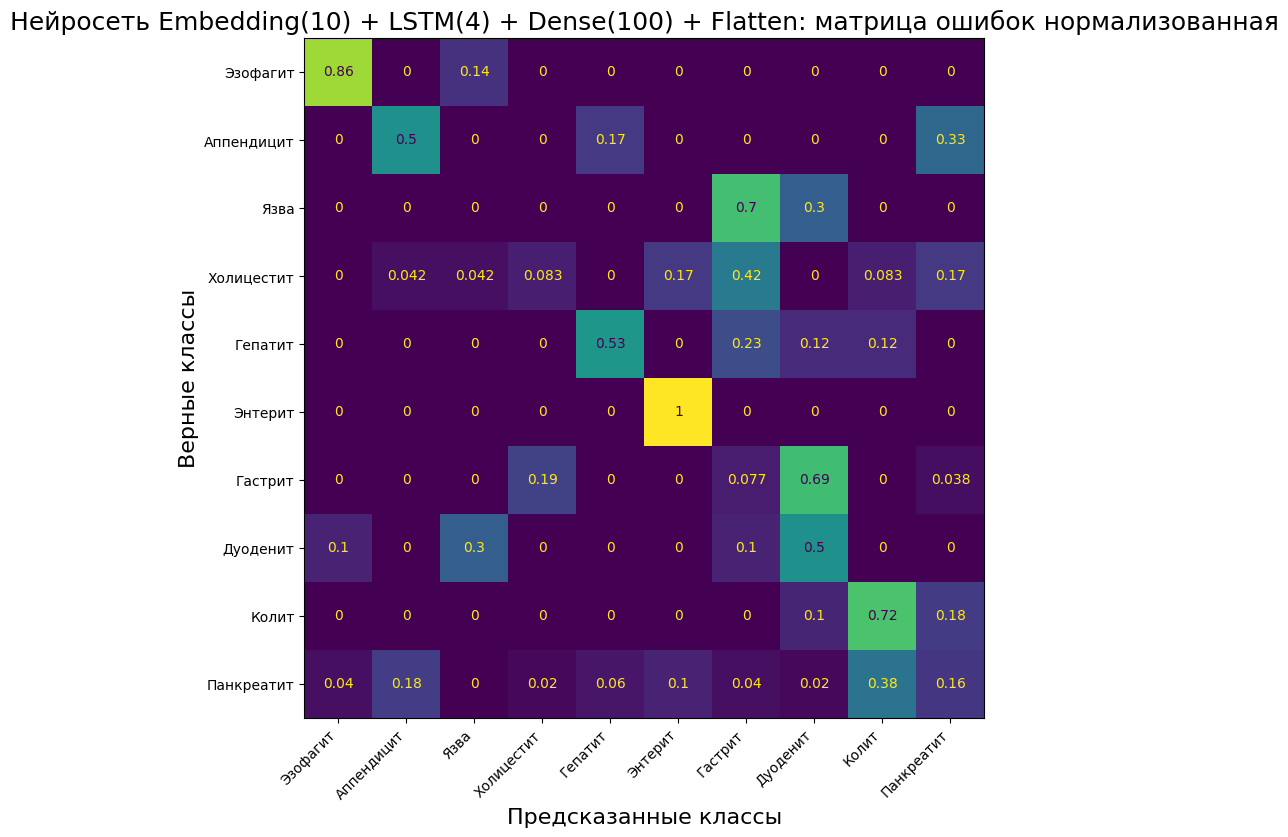

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(10) + LSTM(4) + Dense(100) + Flatten
Класс: Эзофагит              86% сеть отнесла к классу Эзофагит             - ВЕРНО :-)
Класс: Аппендицит            50% сеть отнесла к классу Аппендицит           - ВЕРНО :-)
Класс: Язва                  70% сеть отнесла к классу Гастрит              - НЕВЕРНО :-(
Класс: Холицестит            42% сеть отнесла к классу Гастрит              - НЕВЕРНО :-(
Класс: Гепатит               53% сеть отнесла к классу Гепатит              - ВЕРНО :-)
Класс: Энтерит              100% сеть отнесла к классу Энтерит              - ВЕРНО :-)
Класс: Гастрит               69% сеть отнесла к классу Дуоденит             - НЕВЕРНО :-(
Класс: Дуоденит              50% сеть отнесла к классу Дуоденит             - ВЕРНО :-)
Класс: Колит                 72% сеть отнесла к классу Колит                - ВЕРНО :-)
Класс: Панкреатит            38% сеть отнес

In [ ]:
compile_train_eval_model(model_LSTM_1,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer=RMSprop(0.001),
                         epochs=50,
                         batch_size=32,
                         class_labels=CLASS_LIST,
                         title='Embedding(10) + LSTM(4) + Dense(100) + Flatten')

In [ ]:
model_LSTM_2 = Sequential()
model_LSTM_2.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_2.add(SpatialDropout1D(0.4))
model_LSTM_2.add(BatchNormalization())

model_LSTM_2.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_2.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_2.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_2.add(Dropout(0.3))
model_LSTM_2.add(BatchNormalization())

model_LSTM_2.add(GRU(16, reset_after=True))
model_LSTM_2.add(Dropout(0.3))
model_LSTM_2.add(BatchNormalization())

model_LSTM_2.add(Dense(200, activation='relu'))
model_LSTM_2.add(Dropout(0.3))
model_LSTM_2.add(BatchNormalization())
model_LSTM_2.add(Dense(CLASS_COUNT, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            250000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_4 (Batc  (None, 50, 50)           200       
 hNormalization)                                                 
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 16)           3776      
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 16)           1600      
 nal)                                                 

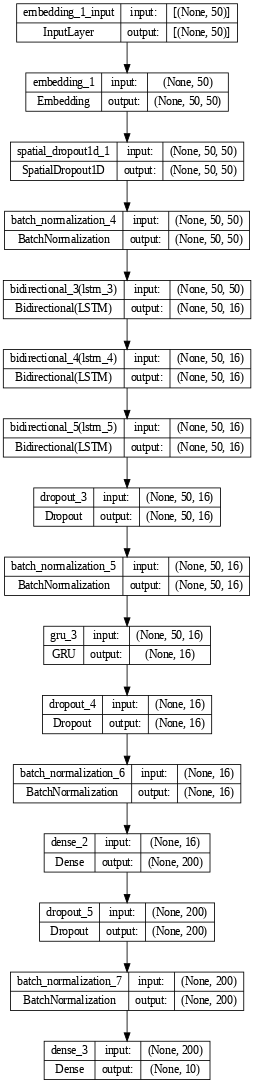

Epoch 1/50
39/39 [==============================] - 15s 121ms/step - loss: 2.7558 - accuracy: 0.1164 - val_loss: 2.2571 - val_accuracy: 0.2146
Epoch 2/50
39/39 [==============================] - 3s 77ms/step - loss: 2.2774 - accuracy: 0.2303 - val_loss: 2.2452 - val_accuracy: 0.2146
Epoch 3/50
39/39 [==============================] - 3s 83ms/step - loss: 1.6970 - accuracy: 0.3967 - val_loss: 2.2380 - val_accuracy: 0.2318
Epoch 4/50
39/39 [==============================] - 3s 73ms/step - loss: 1.3371 - accuracy: 0.5057 - val_loss: 2.2170 - val_accuracy: 0.1116
Epoch 5/50
39/39 [==============================] - 3s 72ms/step - loss: 0.9353 - accuracy: 0.6713 - val_loss: 2.3063 - val_accuracy: 0.0730
Epoch 6/50
39/39 [==============================] - 3s 78ms/step - loss: 0.8415 - accuracy: 0.7057 - val_loss: 2.1527 - val_accuracy: 0.2017
Epoch 7/50
39/39 [==============================] - 4s 92ms/step - loss: 0.5936 - accuracy: 0.7885 - val_loss: 1.8739 - val_accuracy: 0.4077
Epoch 8/50


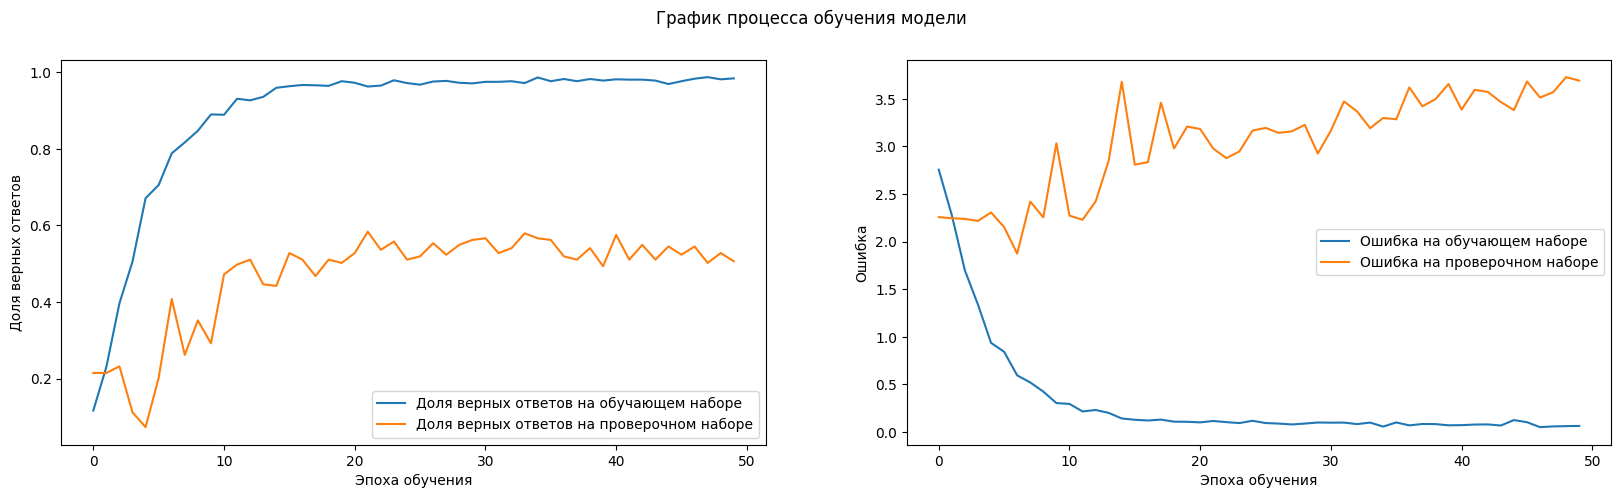

8/8 [==============================] - 2s 13ms/step


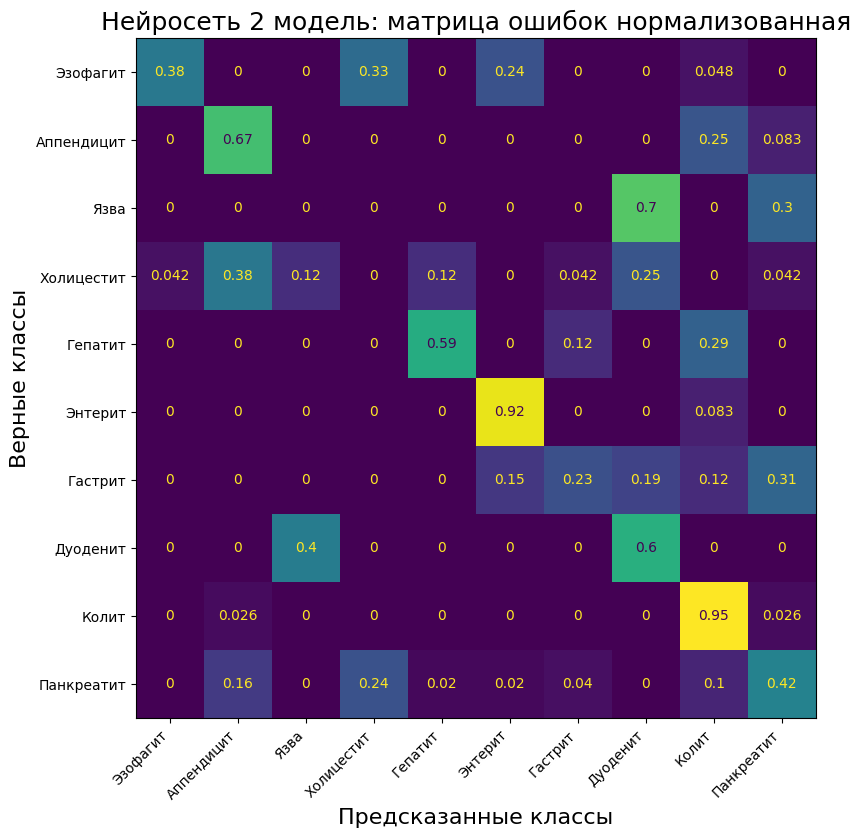

----------------------------------------------------------------------------------------------------
Нейросеть: 2 модель
Класс: Эзофагит              38% сеть отнесла к классу Эзофагит             - ВЕРНО :-)
Класс: Аппендицит            67% сеть отнесла к классу Аппендицит           - ВЕРНО :-)
Класс: Язва                  70% сеть отнесла к классу Дуоденит             - НЕВЕРНО :-(
Класс: Холицестит            38% сеть отнесла к классу Аппендицит           - НЕВЕРНО :-(
Класс: Гепатит               59% сеть отнесла к классу Гепатит              - ВЕРНО :-)
Класс: Энтерит               92% сеть отнесла к классу Энтерит              - ВЕРНО :-)
Класс: Гастрит               31% сеть отнесла к классу Панкреатит           - НЕВЕРНО :-(
Класс: Дуоденит              60% сеть отнесла к классу Дуоденит             - ВЕРНО :-)
Класс: Колит                 95% сеть отнесла к классу Колит                - ВЕРНО :-)
Класс: Панкреатит            42% сеть отнесла к классу Панкреатит           - ВЕР

In [ ]:
compile_train_eval_model(model_LSTM_2,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer=RMSprop(0.001),
                         epochs=50,
                         batch_size=32,
                         class_labels=CLASS_LIST,
                         title='2 модель')